
# Code for Master's Thesis: Topic Modeling

## Research Questions

1. Welche Themen können mithilfe von Topic Modeling aus den DHd-Abstracts
der Tagungen zwischen 2014 und 2023 gefunden werden?

*Which topics can be found in the abstracts from DHd-conferences between 2014 and 2023 with Topic Modeling?*

2. Welche Themen kommen häufig gemeinsam in einem Dokument vor und weisen
daher eine hohe Themenähnlichkeit (topic similarity) auf?

*Which topics appear frequently in one abstract and therefore have a high topic similarity?* **Hierarchical Clustering**

3. Wie haben sich die Themenschwerpunkte im Verlauf der Jahre verändert -
welche Trends sind zu erkennen?

*How have the topics been changing throughout the years - which trends are perceptible?* **Mann-Kendall-Test**

4. Welche Entwicklungen sind in Bezug auf die Verwendung verschiedener Forschungsmethoden festzustellen?

*Which developments with regard to the use of different scientific methods are perceptible?*

5. Welche Personen sind besonders häufig mit Abstracts vertreten, in welchen
Autor:innenteams treten sie auf und wie verändern sich diese im Zeitverlauf?

*Which researchers contribute to the conference particularly frequently with abstracts, in which teams do they contribute and how have the teams been changing?*

6. Welche Personencluster sind in Bezug auf die Themenschwerpunkte zu erkennen und wie verändern sich diese?

*Which clusters of researchers can be found with regard to topics and how have the clusters been changing?* **Network Analysis**

### Imports

In [1]:
#Reading in necessary pdf- and xml-files
import zipfile
from bs4 import BeautifulSoup
'''Vermerken: PyPDF2 hat die Zeichen nicht gut erkannt und daher sind einige Wörter herausgefallen'''
import PyPDF2
import fitz
from io import BytesIO

#(pre)processing the files
import re
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
import spacy
from langdetect import detect
from gensim.models import TfidfModel
import pickle

#LDA
import gensim
import gensim.corpora as corpora
import os

#Evaluation
from gensim.models import CoherenceModel
import numpy as np
import matplotlib.pyplot as plt

#Visualisations
import pandas as pd
import pyLDAvis
import pyLDAvis.gensim_models
import scipy.cluster.hierarchy as shc

#Hellinger Distance
from gensim.matutils import hellinger
from scipy.spatial.distance import squareform

#Mann-Kendall-Test
import pymannkendall as mk

#Network Analysis
from pyvis.network import Network
import networkx as nx



### General functions: opening lists, saving and reopening objects

In [287]:
def open_list(doc_name):
    file = open(doc_name, "r", encoding='utf-8')
    data = file.read()

    data = data.split(", ")
    return data
    file.close()

In [288]:
def save_object(dirname, filename, varname):
    filename = dirname + filename
    g = open(filename, 'wb')
    pickle.dump(varname, g)
    g.close()

In [289]:
def open_variable(dirname, filename, varname):
    path = str(dirname) + str(filename)
    f = open(path, 'rb')
    varname = pickle.load(f)
    f.close()
    return varname 

### Preprocessing function: eliminating non-German texts from corpus

In [2]:
def detect_language(text):
    
    #gets text as input
    lang = detect(text)

    #returns the language tag of detected language
    return lang        

### Preprocessing function: cleaning the texts

In [3]:
def clean_text(text):
        
    # filtering paragraphs from text
    clean = re.sub(r'\n', "", str(text))

    # filtering abbreviations, weblinks, digits and markup from XML      
    abbreviations = ['bspw.', 'sog.', 'vgl.', 'u.a.', 'z.B.', 'bzw.', r'http(.*?) ', r'\d', r'<(.*?)>', 'e.g.', 'also']
    for word in abbreviations:
        clean = re.sub(word, '', clean)

    # filtering punctuation
    punctuation = '''!“()´`¨[]{}\\;:”",<>/.?@#$%^&*_~''' 
    for word in clean:
        if word in punctuation:
            clean = clean.replace(word, "")

    # returns cleaned-up texts
    return clean

### Preprocessing function: removing stopwords and very short/long words

In [290]:
additional_stops = open_list('additional_stopwords.txt')

def remove_stopwords(text, language):
    
    # import German stopword list 
    stops_de = set(stopwords.words('german'))
    stops_de.update(additional_stops)
    
    stops_en = set(stopwords.words('english'))
    stops_en.update(additional_stops)
    
    # convert a document into a list of lowercase tokens, ignoring tokens that are too short (min_len=2) or too long (max_len=15), no deaccentation (by default)
    words = gensim.utils.simple_preprocess(text)
    
    # filter stopwords
    words_filtered = []
    for w in words:
        if language == 'de':
            if w not in stops_de:
                words_filtered.append(w)
        elif language == 'en':
            if w not in stops_en:
                words_filtered.append(w)
    
    # return list of words that are NOT stopwords
    return words_filtered


### Preprocessing function: (morpho-syntactic) lemmatization
- Lemmatizing the words in the texts to their dictionary form according to the detected language
- Hint: 'de_core_news_md' and 'en_core_web_sm' models have to be downloaded via pip beforehand

In [5]:
def lemmatization(texts, language):
    
    # only words tagged as nouns, verbs, adjectives and adverbs should be considered
    allowed_tags = ['NOUN', 'VERB', 'ADJ', 'ADV']

    # disabling parser and ner-tool to accelerate computing 
    nlp_de = spacy.load('de_core_news_md', disable=['parser', 'ner'])
    nlp_en = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    texts_out = []
    for text in texts:
        if language == 'de':
            doc = nlp_de(text)
            new_text = []
            for token in doc:
                if token.pos_ in allowed_tags:
                    new_text.append(token.lemma_.lower())
        elif language == 'en':
            doc = nlp_en(text)
            new_text = []
            for token in doc:
                if token.pos_ in allowed_tags:
                    new_text.append(token.lemma_.lower())
            
        # delete all empty sets where the pos-tag was not in allowed list
        if new_text != []:        
            final = " ".join(new_text)
            texts_out.append(final)
    
    # return list of lemmatized words
    return (texts_out)

### Function: Extracting Keywords from XML-File
- extracts tags \<keywords n="topics" scheme="ConfTool"> and \<keywords n="keywords" scheme="ConfTool"> to get keywords of the texts
- checks validity of keywords

In [94]:
def clean_keywords(keywords):
    keywords = re.sub("<(.*?)>", "", keywords)
    keywords = keywords.split("\n")
    for item in keywords:
        if len(item) <= 2:
            keywords.remove(item)
    return keywords

In [95]:
def extract_keywords(xmldata, conf_tool_methods):
    
    # finds all tags <keywords n="keywords"> and <keywords n="topics">, removes all tags within
    keywords_free= str(xmldata.find_all('keywords', n='keywords'))
    keywords_conf = str(xmldata.find_all('keywords', n='topics'))
    
    keywords_free = clean_keywords(keywords_free)
    keywords_conf = clean_keywords(keywords_conf)
    for item in keywords_conf:
        if item not in conf_tool_methods:
            keywords_conf.remove(item)
            
    # returns list
    return keywords_free, keywords_conf

### Function: Counting number of extracted keywords/authors/etc.
- function creates dictionary from the input list
- counts how often each method/author is used or appears
- returns the dictionary

In [7]:
def count_appearances(list):
    
    methods_dict = {}
    # for each item in keyword list, check if it is alredy in dictionary
    # if not, add and set count to 1, if yes add +1 to count
    for item in list:
        if item not in methods_dict.keys():
            methods_dict[item] = 1
        else:
            methods_dict[item] += 1
    # sort dictionary according to highest count in the values
    sorted_dict = sorted(methods_dict.items(), key=lambda x: x[1], reverse=True)

    # return the sorted dictionary (becomes list through sorting though)
    return sorted_dict

### Function: Extracting the author names
Extracts the names of the authors and returns a list of lists containing the names of the single texts' authors

In [8]:
def extract_authors(title_stmt):
    # returns a list of authors for each of the texts
    
    # navigating to the title statement and finding all tags <author>
    authors = title_stmt.find_all("author")
    fore_and_surnames = []
    
    # extracting the <surname> and <forename> tags and cleaning the outcome from the tags and the brackets
    for element in authors:
        names = element.find_all(['surname', 'forename'])
        names =  re.sub("<(.*?)>", "", str(names))
        names = re.sub("</(.*?)>", "", str(names))
        names = re.sub(r'\]', "", names)
        names = re.sub(r'\[', "", names)
        fore_and_surnames.append(names)
    # all_authors.append(fore_and_surnames)
    
    return fore_and_surnames

### Function: Extracting text from XML-files

In [9]:
def extract_xml_text(soup):
    
    # extract <p> tags from body of xml-document to find the actual text 
    document_body = soup.body
    p_tags = document_body.find_all("p")
    
    # return the text from p-tags
    return p_tags

### Functions: Making bigrams and trigrams

In [10]:
def make_bigrams(texts, bigram):
    return([bigram[doc] for doc in texts])

def make_trigrams(texts, trigram,bigram):
    return ([trigram[bigram[doc]] for doc in texts])

In [11]:
def create_bigrams_trigrams(texts):
   
    bigram_phrases = gensim.models.Phrases(texts, min_count=5, threshold=100)
    trigram_phrases = gensim.models.Phrases(bigram_phrases[texts], threshold=100)

    bigram = gensim.models.phrases.Phraser(bigram_phrases)
    trigram = gensim.models.phrases.Phraser(trigram_phrases)

    data_bigrams = make_bigrams(texts, bigram)
    data_bigrams_trigrams = make_trigrams(data_bigrams, trigram, bigram)

    return data_bigrams_trigrams

### Function: Creating bag of words

In [12]:
def create_bow(data_words): 
    
    # mapping the documents' words to a dictionary   
    id2word = corpora.Dictionary(data_words)

    # creating a bag of words by using index of dictionary
    bag_of_words_corpus = []
    for text in data_words:
        new = id2word.doc2bow(text)
        bag_of_words_corpus.append(new)

    # returning id2word-reference as well as bag of word itself, both needed for LDA    
    return id2word, bag_of_words_corpus

### Function: TF-IDF weighting

In [13]:
def tf_idf(id2word, texts):
    # simple bag of words for each document, containing tuples with (index, number of appearances of the word in the document)
    corpus = [id2word.doc2bow(text) for text in texts]

    # calculates term frequency (TF) weighted by the inverse document frequency (IDF) for every word/index in the bag of words
    tfidf = TfidfModel(corpus, id2word=id2word)

    # low_value as threshold
    low_value = 0.03
    words  = []
    words_missing_in_tfidf = []

    # for every single bag of words
    for i in range(0, len(corpus)):
        # consider each bow for each document
        bow = corpus[i]
        #low_value_words = [] #reinitialize to be safe. You can skip this.
        
        # for each tuple (index, tfidf-value) in the tf-idf-weighted bag of words, extract index (tfidf_ids)
        tfidf_ids = [id for id, value in tfidf[bow]]
        
        # for each tuple (index, bow-value without tfidf), extract index
        bow_ids = [id for id, value in bow]
        
        # if the value in the (index, tfidf-value) tuple is lower than 0.03, put id into list low_value_words
        low_value_words = [id for id, value in tfidf[bow] if value < low_value]
        
        drops = low_value_words+words_missing_in_tfidf
        
        # which words will be deleted from the bow?
        for item in drops:
            words.append(id2word[item])
    
        words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf score 0 will be missing
        
        # add words which indexes are not in low_value_words and not in words_missing_in_tfidf to the new bag of words 
        new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
        
        # new bow is missing certain indexes
        corpus[i] = new_bow
    
    return corpus

## Main Code:

Creating repositories in which variables, models and figures can be saved later

In [14]:
if not os.path.isdir("Variables/"):
    os.mkdir('Variables/')
    print('Created new directory: Variables')
    
if not os.path.isdir('Figures/'):
    os.mkdir('Figures/')
    print('Created new directory: Figures')
    
if not os.path.isdir('Models/'):
    os.mkdir('Models/')
    print('Created new directory: Models')

Reading in zip-files of DHd-conferences where only PDF-files are accessible

In [15]:
# filenames_pdf = ['DHd_2014.zip', 'DHd_2015.zip']
filenames_pdf = ['DHd_2014.zip']

# extracting text from pdf-files
all_pdf_texts = []
doc_names_pdf = []
for conference_file in filenames_pdf:
    archive = zipfile.ZipFile(conference_file, 'r')
    doc_names_year = []
    for name in archive.namelist():
        if name[-4:] == '.pdf':
            doc_names_year.append(name)
            pdf_data = BytesIO(archive.read(name))
            # reading each pdf-file in the zip-archive
            with fitz.open(stream=pdf_data, filetype='pdf') as doc:
                text = ''
                for page in doc:
                    text += page.get_text()
                all_pdf_texts.append(text)
    doc_names_pdf.append(doc_names_year)
print(doc_names_pdf)

[['DHd-Verband-DHd-Abstracts-2014-667e2de/PDF-files/ARZHANOV_Yuri_The_Glossarium.pdf', 'DHd-Verband-DHd-Abstracts-2014-667e2de/PDF-files/BARTZ, Thomas_Disambiguierung_in_Suchtrefferlisten.pdf', 'DHd-Verband-DHd-Abstracts-2014-667e2de/PDF-files/BARZEN_Johanna_Kostümsprachen_als_Mustersprachen.pdf', 'DHd-Verband-DHd-Abstracts-2014-667e2de/PDF-files/BIBER_Hanno_AAC_FACKEL_Das_Beispiel_einer_digitalen_Musteredition.pdf', 'DHd-Verband-DHd-Abstracts-2014-667e2de/PDF-files/BIEHL_Theresia_Vernetzte_Korrespondenzen_Erforschung_und_Visualisierung_sozialer.pdf', 'DHd-Verband-DHd-Abstracts-2014-667e2de/PDF-files/BINDER_Frank_GeoBib_Georeferenzierte_Online_Bibliographie_früher.pdf', 'DHd-Verband-DHd-Abstracts-2014-667e2de/PDF-files/BINDER_Frank_GeoHumanities_Karten_Daten_Texte_in_den_digitalen_Geisteswissenschaften.pdf', 'DHd-Verband-DHd-Abstracts-2014-667e2de/PDF-files/BISCHOFF_Kerstin_Herausforderungen_und_best_practices.pdf', 'DHd-Verband-DHd-Abstracts-2014-667e2de/PDF-files/BURGHARDT_Manuel_Emp

Reading in the zip-files of the DHd-Conferences where XML-files were published

In [144]:
# filenames_xml = ['DHd_2016.zip']
filenames_xml = ['DHd_2016.zip', 'DHd_2017.zip', 'DHd_2018.zip', 'DHd_2019.zip', 'DHd_2020.zip',
             'DHd_2022.zip', 'DHd_2023.zip']


all_xml_files = []
doc_names_xml = []
# read in all zip-folders
for conference_file in filenames_xml:
    archive = zipfile.ZipFile(conference_file, 'r')
    doc_names_year = []
    xml_per_year = []
    # read in all files in the zip-file and check that they are xml-files
    for name in archive.namelist():
        if name[-4:] == '.xml' and not name[-9:] == 'final.xml':
            xml_per_year.append(archive.read(name))
            doc_names_year.append(name)
    all_xml_files.append(xml_per_year)
    # creating a list of all documents' names
    doc_names_xml.append(doc_names_year)


docnames = doc_names_pdf + doc_names_xml
filenames = filenames_pdf + filenames_xml

XML-Files: 

The XML-files are not only used for text extraction, but since they contain a lot of information due to the extensive markup, some other information will be extracted from the files in the following steps:
- Text 
- Authors of the documents
- Keywords given in the metadata of the abstracts in order to find the scientific methods used

In [270]:
# Creating dictionary to count how often each method is used

all_xml_texts = []

# contains a list per year, this list contains a list of keywords extracted per text
all_free_keywords = []
keywords_free_total = []
all_conf_keywords = []
keywords_conf_total = []
methods_free = []
methods_conf = []
authors = []
authors_full_list = []

for year in all_xml_files:
    keywords_free_year = []
    keywords_conf_year = []
    authors_year = []
    for doc in year:
        
        soup = BeautifulSoup(doc, 'xml')
        
        # Code for extracting the actual text from xml-files
        xml_text = extract_xml_text(soup)
        all_xml_texts.append(xml_text)
        
        
        # Code for extracting the author names       
        title_stmt = soup.titleStmt
        authors_in_doc = extract_authors(title_stmt)
        # print(authors_in_doc)
        authors_year.append(authors_in_doc) 

        
        # Code for extracting the keywords used in xml-files  (per year)
        keywords_free, keywords_conf = extract_keywords(soup, conf_tool_methods)  
        keywords_free_year = keywords_free_year + keywords_free
        keywords_conf_year = keywords_conf_year + keywords_conf
        
    # saving all keywords that were given in the <keyword n=keyword> tags in the XML-files
    
    all_free_keywords = list(dict.fromkeys(all_free_keywords + keywords_free_year))
    keywords_conf_total.append(keywords_conf_year)    
    keywords_free_total.append(keywords_free_year)  
    
    # saves the methods used within one year and their respective count
    # methods_free_count = count_appearances(keywords_free_year)
    # methods_free.append(methods_free_count)
    # methods_conf_count = count_appearances(keywords_conf_year)
    # methods_conf.append(methods_conf_count)
    
    
    # saves each text's authors in a list, sorted by year of the text
    authors.append(authors_year)
    
    
    for element in authors_year:
        authors_full_list = authors_full_list + element


Merging the extracted PDF and XML texts for further processing of the textual content:

- Cleaning up
- Removing stopwords depending on the detected language (English or German)
- Lemmatizing the texts depending on the detected language (English or German) --> time-consuming step

In [39]:
''' Do not exert if you have the variables stored!! '''
whole_texts = []
whole_texts = all_pdf_texts + all_xml_texts

list_all_texts = []
for text in whole_texts:
    # detecting language in order to remove the stopwords and lemmatize according to language
    lang = detect_language(str(text))     
    text_item = clean_text(text)
    text_item = remove_stopwords(text_item, lang)
    text_item = lemmatization(text_item, lang)
    list_all_texts.append(text_item)

''' Do not exert if you have the variables stored!! '''

' Do not exert if you have the variables stored!! '

Creating bigrams and trigrams, id2word and bag of words, which are necessary for the actual topic modeling algorithm (LDA)

In [42]:
# creating bigrams and trigrams from lemmatized words
data_bigrams_trigrams = create_bigrams_trigrams(list_all_texts)

# id2word as dictionary where every word/bi-/trigram is referenced with id
id2word = corpora.Dictionary(data_bigrams_trigrams)

# corpus as dictionary that contains a list of tuples for each document, tuples contain (id, no. of appearances of the word)
# some index numbers are missing due to the tf-idf weighting 
corpus = tf_idf(id2word, data_bigrams_trigrams)


In [21]:
def save_object(dirname, filename, varname):
    filename = dirname + filename
    g = open(filename, 'wb')
    pickle.dump(varname, g)
    g.close()

def open_variable(dirname, filename, varname):
    path = str(dirname) + str(filename)
    f = open(path, 'rb')
    varname = pickle.load(f)
    f.close()
    return varname   

Saving or opening the variables again for further use

In [20]:
# writing the files to save the variables

save_object('Variables/', 'corpus.pckl', corpus)
save_object('Variables/', 'id2word.pckl', id2word)
save_object('Variables/', 'list_all_texts.pckl', list_all_texts)
save_object('Variables/', 'data_bigrams_trigrams.pckl', data_bigrams_trigrams)

NameError: name 'save_object' is not defined

In [22]:
# opening the saved variables for reuse

corpus = open_variable('Variables/', 'corpus.pckl', 'corpus')
id2word = open_variable('Variables/', 'id2word.pckl', 'id2word')
list_all_texts = open_variable('Variables/', 'list_all_texts.pckl', 'list_all_texts')
data_bigrams_trigrams = open_variable('Variables/', 'data_bigrams_trigrams.pckl', 'data_bigrams_trigrams')


In [20]:
print(corpus[:10])
print(id2word)
print(list_all_texts[:10])
print(data_bigrams_trigrams[-10:])

[[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 12), (7, 4), (8, 1), (9, 1), (10, 1), (11, 1), (14, 3), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 2), (29, 2), (30, 1), (32, 1), (33, 4), (34, 2), (35, 1), (36, 1), (37, 1), (39, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (57, 1), (58, 2), (59, 1), (60, 1), (61, 4), (62, 8), (63, 1), (64, 1), (65, 2), (66, 1), (68, 1), (72, 2), (73, 2), (74, 2), (75, 1), (76, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (86, 1), (87, 2), (89, 1), (90, 1), (91, 2), (92, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (104, 3), (107, 4), (108, 1), (110, 1), (111, 1), (113, 1), (114, 1), (115, 1), (117, 1), (118, 2), (119, 2), (120, 2), (121, 3), (122, 2), (123, 2), (124, 1), (125, 4), (126, 2), (127, 1), (128, 1), (129, 2), (1

### Topic Modeling (LDA)
#### Tuning (hyper-)parameters: Find optimal settings for topic number, update every, alpha and eta

By measuring the quality measures of *perplexity* and *topic coherence*, the ideal parameters for the topic model should be found. 


**Quality Measure: Perplexity**

- Perplexity can be used to measure how good the LDA model generalizes on the text corpus (Blei et al., 2003)
- the lower the perplexity, the better the model

**Quality Measure: Topic Coherence** 

- Topic Coherence can be determined by various measurements - e.g. UMass, C_V, UCI, NPMI - which all use different measurements to calculate the coherence of topics (Röder et al., 2015, p. 2)
- In this workflow, C_V is used: measurement gives values between 0 and 1, with 1 being the best coherence to be reached

**Parameter topic number**

- According to [Kumar (2018)](https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/), "[c]hoosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics". However, "[i]f you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large". (ibid.)

**Parameter update_every**

- "Number of documents to be iterated through for each update. Set to 0 for batch learning, > 1 for online iterative learning." ([Gensim Documentation](https://radimrehurek.com/gensim/models/ldamodel.html))

**Parameter Alpha**

- "A-priori belief on document-topic distribution" ([Gensim Documentation](https://radimrehurek.com/gensim/models/ldamodel.html))
"Alpha is the parameter, which has the smoothing effect on the topic-document distribution and ensures that the probability of each topic in each document is not 0 throughout the entire inference procedure" (Du, 2022, p. 1). Du's study results indicate that coherence results of models deteriorate with increasing Alpha-parameter, and Du concludes that Alpha of each topic should not be higher than 1 (Du, 2022, p. 2)

**Parameter Eta**

- "[D]istributional profile of topics in each document” (Abs. 20) (Schöch, 2017),
- "A-priori belief on topic-word distribution" ([Gensim Documentation](https://radimrehurek.com/gensim/models/ldamodel.html))

In [44]:
def compute_quality_measures(dictionary, corpus, texts, coherence, iterations, topic_optim, update_optim, alpha_optim, eta_optim):
    
    # necessary lists (to be returned)
    coherence_values = []
    model_list = []
    perplexity_values = []
    topic_coherence_values=[]
    model_names = []
    
    for topics_num in topic_optim:
        for update_interval in update_optim:
            for alpha_value in alpha_optim:
                for eta_value in eta_optim:
                    model=gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, iterations=iterations, num_topics=topics_num,  
                                                        update_every=update_interval, alpha=alpha_value, eta=eta_value, minimum_probability=1e-8)
                    model_list.append(model)
                    perplexity_values.append(model.log_perplexity(corpus))
                    coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence=coherence)
                    coherence_values.append(coherencemodel.get_coherence())
                    topic_coherence_values.append(coherencemodel.get_coherence_per_topic())
                    name = (str(topics_num), str(update_interval), str(alpha_value), str(eta_value))
                    model_names.append(name)
                    name = ''
                    ''' For controlling the progress of this very time-consuming step in the workflow, print every parameter that has been checked '''
                    print('   topics_num: ', topics_num, '   update_interval: ', update_interval, '   alpha_value: ', alpha_value, '   eta_value: ', eta_value)
        

    return model_list, perplexity_values, coherence_values, topic_coherence_values, model_names

Finding the ideal topic number *k* by trying out different values for *k*, while all other parameters stay the same and have the default values. 

   topics_num:  5    update_interval:  1    alpha_value:  symmetric    eta_value:  symmetric
   topics_num:  10    update_interval:  1    alpha_value:  symmetric    eta_value:  symmetric
   topics_num:  15    update_interval:  1    alpha_value:  symmetric    eta_value:  symmetric
   topics_num:  20    update_interval:  1    alpha_value:  symmetric    eta_value:  symmetric
   topics_num:  25    update_interval:  1    alpha_value:  symmetric    eta_value:  symmetric
   topics_num:  30    update_interval:  1    alpha_value:  symmetric    eta_value:  symmetric
   topics_num:  35    update_interval:  1    alpha_value:  symmetric    eta_value:  symmetric
   topics_num:  40    update_interval:  1    alpha_value:  symmetric    eta_value:  symmetric
   topics_num:  45    update_interval:  1    alpha_value:  symmetric    eta_value:  symmetric
   topics_num:  50    update_interval:  1    alpha_value:  symmetric    eta_value:  symmetric
   topics_num:  55    update_interval:  1    alpha_value:  sy

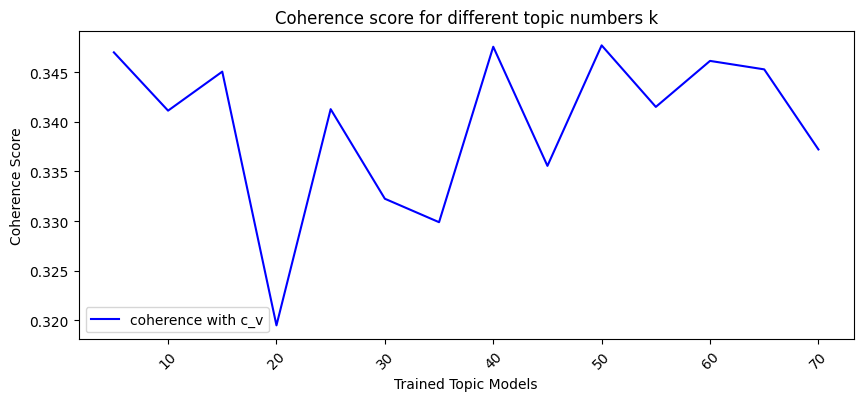

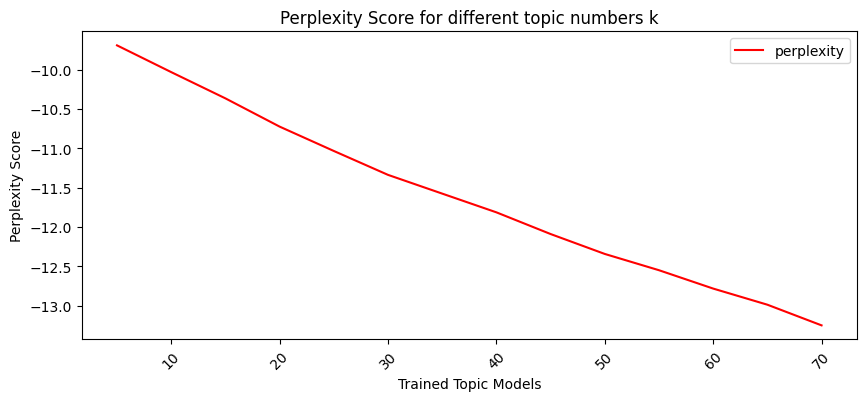

In [42]:
# initializing random seed to be able to reproduce the results
np.random.seed(2)

# running the function with default values except for the topic number
k_model_list_cv, k_perplexity_values, k_coherence_values_cv, k_topic_coherence_values_cv, k_model_names = compute_quality_measures(dictionary=id2word, 
                                                                                        corpus=corpus, 
                                                                                        texts=data_bigrams_trigrams, 
                                                                                        coherence="c_v", 
                                                                                        iterations = 50, 
                                                                                        topic_optim = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70], 
                                                                                        update_optim = [1], 
                                                                                        alpha_optim = ['symmetric'],
                                                                                        eta_optim = ['symmetric'])

# Plotting Coherence Scores
plt.figure(figsize=(10,4))
plt.plot([5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70], k_coherence_values_cv, label ='coherence with c_v', color='blue')
plt.title("Coherence score for different topic numbers k")
plt.xlabel("Trained Topic Models")
plt.ylabel("Coherence Score")
plt.legend()
plt.xticks(rotation=45)
plt.savefig('Figures/Optimization_NumTopics_CoherenceScores.png')
plt.show()

# Plotting Perplexity Scores
plt.figure(figsize=(10,4))
plt.plot([5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70], k_perplexity_values, label ='perplexity', color='red')
plt.title("Perplexity Score for different topic numbers k")
plt.xlabel("Trained Topic Models")
plt.ylabel("Perplexity Score")
plt.legend()
plt.xticks(rotation=45)
plt.savefig('Figures/Optimization_NumTopics_PerplexityScores.png')
plt.show()

Choose either 25, 40 or 50 topics according to **topic coherence**:

25:
- coherence score: 0.3412805135341495
- the k which comes after the steepest ascent 
- after k=25, the curve will be on average at the same coherence as it is with k=25

40:
- coherence score: 0.34756939287436656
- gives the highest coherence score (slightly lower than k=50, though), with the least topics

50: 
- coherence score: 0.34770882503937417 
- overall highest coherence score


**Perplexity** does not really help to find the optimal number of topics *k*, as it decreases with an increasing number of topics *k* and therefore advocates for a really high number of topics which might not be helpful in the end.


Therefore, in the following, k=[25, 40, 50] will be used to fine-tune the other parameters mentioned above. The model with the best coherence score (and perplexity?) will be taken for the rest of the analysis. 

In [91]:
# initializing random seed to be able to reproduce the results
np.random.seed(3)

# running the function to find the optimal combination of parameters
model_list_cv, perplexity_values, coherence_values_cv, topic_coherence_values_cv, model_names = compute_quality_measures(dictionary=id2word, 
                                                                                                                         corpus=corpus, 
                                                                                        texts=data_bigrams_trigrams, 
                                                                                        coherence="c_v", 
                                                                                        iterations = 50,
                                                                                        topic_optim = [25, 40, 50], 
                                                                                        update_optim = [0, 1, 50, 100, 300, 500, 1000, 2000], 
                                                                                        alpha_optim = ['symmetric', 'asymmetric', 'auto'],
                                                                                        eta_optim = ['symmetric', 'auto'])

   topics_num:  25    update_interval:  0    alpha_value:  symmetric    eta_value:  symmetric
   topics_num:  25    update_interval:  0    alpha_value:  symmetric    eta_value:  auto
   topics_num:  25    update_interval:  0    alpha_value:  asymmetric    eta_value:  symmetric
   topics_num:  25    update_interval:  0    alpha_value:  asymmetric    eta_value:  auto
   topics_num:  25    update_interval:  0    alpha_value:  auto    eta_value:  symmetric
   topics_num:  25    update_interval:  0    alpha_value:  auto    eta_value:  auto
   topics_num:  25    update_interval:  1    alpha_value:  symmetric    eta_value:  symmetric
   topics_num:  25    update_interval:  1    alpha_value:  symmetric    eta_value:  auto
   topics_num:  25    update_interval:  1    alpha_value:  asymmetric    eta_value:  symmetric
   topics_num:  25    update_interval:  1    alpha_value:  asymmetric    eta_value:  auto
   topics_num:  25    update_interval:  1    alpha_value:  auto    eta_value:  symmetric
  

In [92]:
i = 0
for i in range(len(model_list_cv)):
    print(i,'   perplexity_value: ', perplexity_values[i], '   coherence_value: ', coherence_values_cv[i], '   model names: ', model_names[i], '\n')
    i += 1

0    perplexity_value:  -11.02109996615284    coherence_value:  0.3524812242838372    model names:  ('25', '0', 'symmetric', 'symmetric') 

1    perplexity_value:  -10.57211260476448    coherence_value:  0.35402768612663815    model names:  ('25', '0', 'symmetric', 'auto') 

2    perplexity_value:  -10.97966383199958    coherence_value:  0.33372313878073073    model names:  ('25', '0', 'asymmetric', 'symmetric') 

3    perplexity_value:  -10.567784292041537    coherence_value:  0.3285960772193148    model names:  ('25', '0', 'asymmetric', 'auto') 

4    perplexity_value:  -11.02204603736826    coherence_value:  0.30733489801716657    model names:  ('25', '0', 'auto', 'symmetric') 

5    perplexity_value:  -10.565938971144076    coherence_value:  0.33795151780674687    model names:  ('25', '0', 'auto', 'auto') 

6    perplexity_value:  -10.981935188566847    coherence_value:  0.33961112758838424    model names:  ('25', '1', 'symmetric', 'symmetric') 

7    perplexity_value:  -10.5749104

In [93]:
# saving the variables

save_object('Variables/', 'model_list_cv.pckl', model_list_cv)
save_object('Variables/', 'perplexity_values.pckl', perplexity_values)
save_object('Variables/', 'coherence_values_cv.pckl', coherence_values_cv)
save_object('Variables/', 'topic_coherence_values.pckl', topic_coherence_values_cv)
save_object('Variables/', 'model_names.pckl', model_names)

In [23]:
# opening the variables

model_list_cv = open_variable('Variables/', 'model_list_cv.pckl', 'model_list_cv')
coherence_values_cv = open_variable('Variables/', 'coherence_values_cv.pckl', 'coherence_values_cv')
topic_coherence_values = open_variable('Variables/', 'topic_coherence_values.pckl', 'topic_coherence_values')
model_names = open_variable('Variables/', 'model_names.pckl', 'model_names')
perplexity_values = open_variable('Variables/', 'perplexity_values.pckl', 'perplexity_values')

Creating a plot in order to make better interpretations and to find the optimal parameters

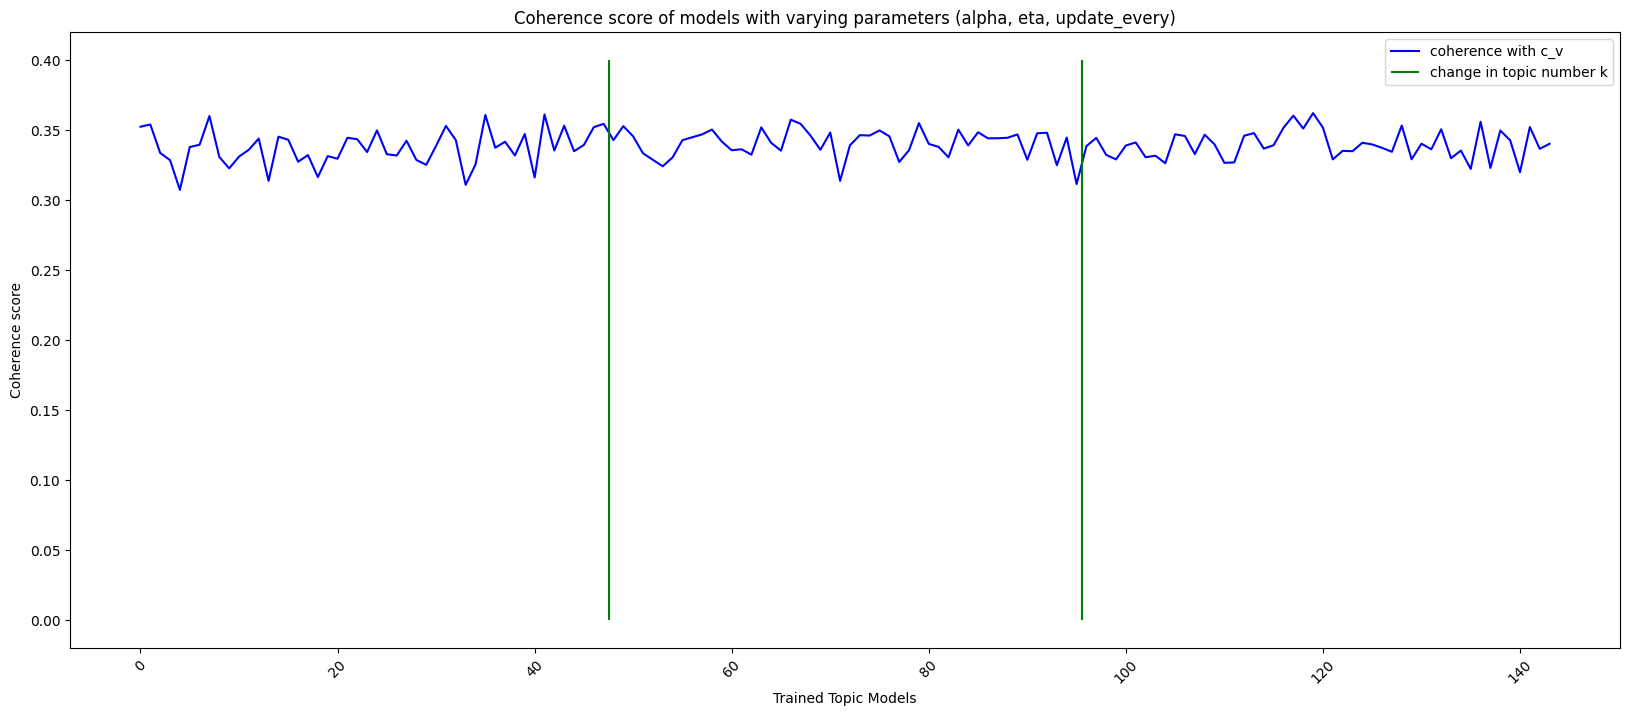

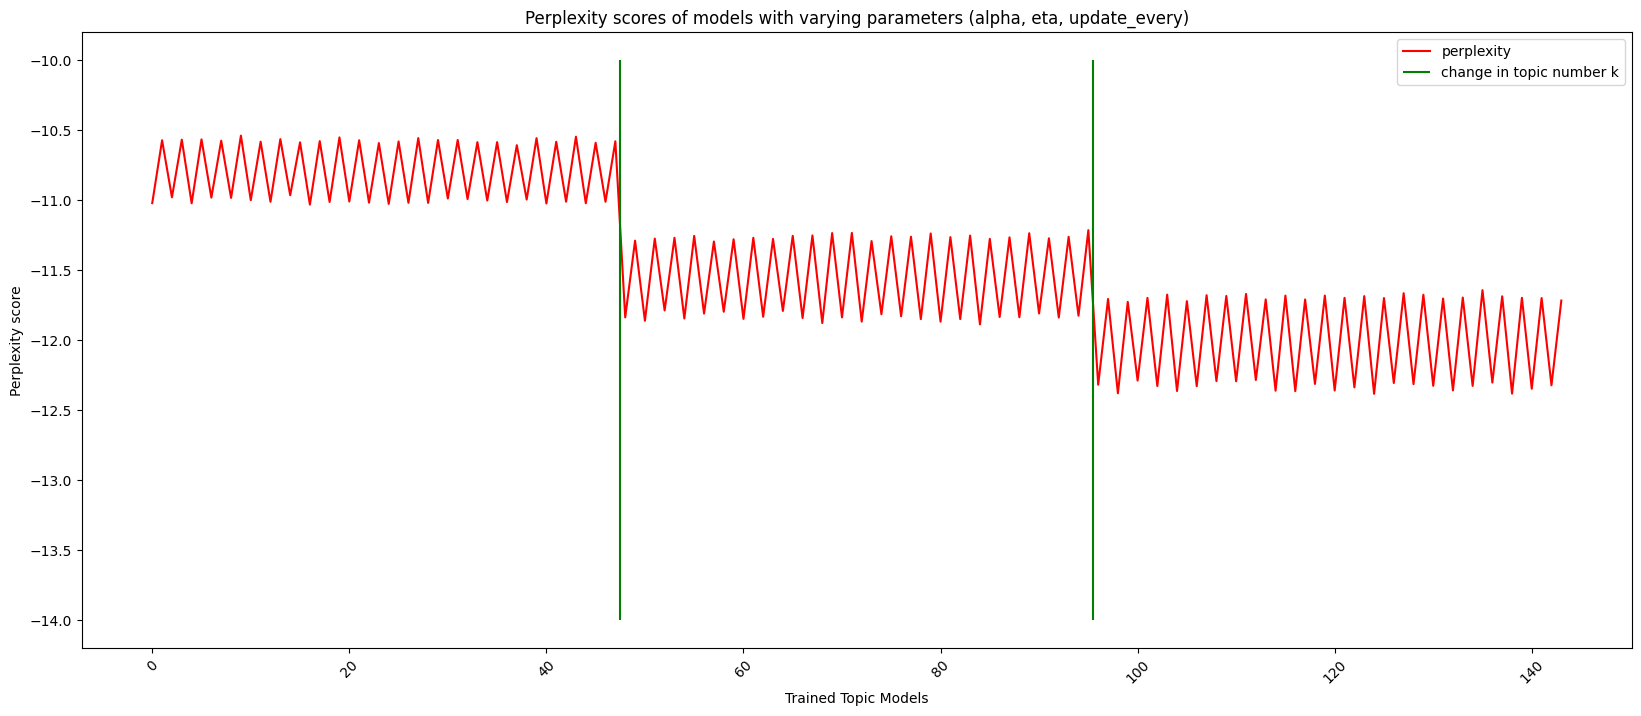

In [24]:
# Customizing and saving the plot
list = []
i = 0
for i in range(len(model_names)):
    list.append(i)
    i += 1

plt.figure(figsize=(20,8))
plt.plot(list, coherence_values_cv, label ='coherence with c_v', color='blue')
plt.title("Coherence score of models with varying parameters (alpha, eta, update_every)")
plt.xlabel("Trained Topic Models")
plt.ylabel("Coherence score")
plt.vlines(x = 47.5, ymin=0, ymax=0.4, color='green', label='change in topic number k')
plt.vlines(x = 95.5, ymin=0, ymax=0.4, color='green')
plt.legend()
plt.xticks(rotation=45)
plt.savefig('Figures/Coherence_25-40-50_HyperpOptim.svg')
plt.show()

plt.figure(figsize=(20,8))
plt.plot(list, perplexity_values, label ='perplexity', color='red')
plt.title("Perplexity scores of models with varying parameters (alpha, eta, update_every)")
plt.xlabel("Trained Topic Models")
plt.ylabel("Perplexity score")
plt.vlines(x = 47.5, color='green', ymin=-14, ymax=-10, label='change in topic number k')
plt.vlines(x = 95.5, ymin=-14, ymax=-10, color='green')
plt.legend()
plt.xticks(rotation=45)
plt.savefig('Figures/Perplexity_25-40-50_HyperpOptim.svg')
plt.show()

Finding the index with the highest coherence and saving that model for further use

In [25]:

''' What about the highest perplexity? Maybe find the model which has good values for both'''

''' Bessere Lösung muss her! '''
highest_coherence = []
for value in coherence_values_cv:
    if value > 0.36:
        highest_coherence.append(coherence_values_cv.index(value))

for element in highest_coherence:
    print(model_names[element])
    print(element)
    print(coherence_values_cv[element])
    print("\n")
    

        

('25', '1', 'symmetric', 'auto')
7
0.3601110158794579


('25', '500', 'auto', 'auto')
35
0.36083964919906075


('25', '1000', 'auto', 'auto')
41
0.36121499621273784


('50', '100', 'asymmetric', 'auto')
117
0.3603888138275536


('50', '100', 'auto', 'auto')
119
0.362210173102012




In [45]:
index_best_model = coherence_values_cv.index(max(coherence_values_cv))

# Select the model and print the topics
optimal_model = model_list_cv[35]
# optimal_model = model_list_cv[index_best_model]
# print(coherence_values_cv[index_best_model])

# print('Number of topics in the best model: ', model_list_cv[index_best_model].num_topics)
# final_num_topics = model_list_cv[index_best_model].num_topics
# optimal_model.save("Models/optimal_model_n17.model", "w")

## Research Question 1: Topic Modeling

Visualisation of final topic modeling with optimal parameters

In [81]:
# model = gensim.models.ldamodel.LdaModel.load("models/optimal_model_n17.model")

In [48]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, corpus, id2word)
pyLDAvis.show(vis, local=False)

Serving to http://127.0.0.1:8888/    [Ctrl-C to exit]


127.0.0.1 - - [31/May/2023 09:14:26] "GET / HTTP/1.1" 200 -
----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 51523)
Traceback (most recent call last):
  File "c:\Users\luisa\AppData\Local\Programs\Python\Python310\lib\socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "c:\Users\luisa\AppData\Local\Programs\Python\Python310\lib\socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "c:\Users\luisa\AppData\Local\Programs\Python\Python310\lib\socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "c:\Users\luisa\AppData\Local\Programs\Python\Python310\lib\socketserver.py", line 747, in __init__
    self.handle()
  File "c:\Users\luisa\AppData\Local\Programs\Python\Python310\lib\http\server.py", line 425, in handle
    self.handle_one_request()
  File "c:\Users\luisa\


stopping Server...


### Further analyses with the optimal topic model from above

For all: https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/topic_methods.ipynb

Getting the most frequent words per topic

In [49]:
optimal_model.show_topics(num_topics=25)

[(0,
  '0.005*"daten" + 0.005*"text" + 0.003*"annotation" + 0.003*"sammlung" + 0.003*"use" + 0.003*"information" + 0.003*"figur" + 0.003*"software" + 0.002*"werk" + 0.002*"analyse"'),
 (1,
  '0.009*"digital" + 0.007*"text" + 0.006*"projekt" + 0.004*"daten" + 0.004*"annotation" + 0.003*"frage" + 0.003*"werk" + 0.003*"konzept" + 0.002*"methode" + 0.002*"deutsch"'),
 (2,
  '0.008*"text" + 0.005*"historisch" + 0.004*"projekt" + 0.004*"abbildung" + 0.003*"werk" + 0.003*"annotation" + 0.003*"autor" + 0.003*"daten" + 0.003*"jahr" + 0.002*"deutsch"'),
 (3,
  '0.006*"daten" + 0.006*"historisch" + 0.005*"digital" + 0.004*"annotation" + 0.003*"modell" + 0.003*"figur" + 0.003*"dokument" + 0.002*"analyse" + 0.002*"edition" + 0.002*"kategorie"'),
 (4,
  '0.012*"digital" + 0.007*"annotation" + 0.005*"projekt" + 0.005*"daten" + 0.003*"analyse" + 0.003*"historisch" + 0.002*"modell" + 0.002*"edition" + 0.002*"information" + 0.002*"quellen"'),
 (5,
  '0.008*"text" + 0.005*"digital" + 0.003*"daten" + 0.00

Showing the probabilities of a certain word to belong to the topics

In [50]:
optimal_model.get_term_topics('lexikalisch')

[(0, 0.00025501623),
 (1, 0.00031436473),
 (2, 0.00012226285),
 (3, 0.00014078649),
 (4, 0.00026945566),
 (5, 0.00021553019),
 (6, 0.00021211426),
 (7, 0.00065594196),
 (8, 0.00016458305),
 (9, 0.00020328643),
 (10, 0.00019183387),
 (11, 0.00024417927),
 (12, 0.00021988283),
 (13, 0.00024991168),
 (14, 0.00029828955),
 (15, 0.00023319668),
 (16, 0.00011625474),
 (17, 2.8780061e-05),
 (18, 0.00012445082),
 (19, 0.00011645637),
 (20, 5.8432368e-05),
 (21, 0.00022116465),
 (22, 5.208464e-05),
 (23, 0.00017408766),
 (24, 4.6406403e-05)]

## Research Question 2: Hierarchical Clustering and Topic Similarity
Hellinger-Distance:
- values between 0 and 1, with 0 = completely similar, 1 = completely different
- compares the probability distribution of topics for two documents
- symmetrical measure, i.e. hellinger(a,b) = hellinger(b,a)
- [Documentation in Gensim](https://radimrehurek.com/gensim/matutils.html#gensim.matutils.hellinger)

Based on document-level similarity, where "topics may appear in some of the same documents" (7884) (Hao et al., 2018) 

--> goal: "describe the interaction structure of research topics" because "[i]f two topics frequently appear in the same publications, there is a big potential to foster a novel interdisciplinary research field" (7889) (Hao et al., 2018)


In [40]:
topics_per_text = []
bow_mann_kendall = []
i = 0

## als Input: Liste von Listen der einzelnen Texte in lemmatisierter/bigramm-Form!

for text in data_bigrams_trigrams:
    #bow-representation of the single text
    bow = optimal_model.id2word.doc2bow(text)
    doc_topics, word_topics, phi_values = optimal_model.get_document_topics(bow, per_word_topics=True)
    
    # #shows the distribution of topics in the single documents
    # print(i, doc_topics)
    
    #saving the topic distribution of each text in a list
    topics_per_text.append(doc_topics)
    i += 1
    
# calculating the distance of each document's topic distribution to any other document's topic distribution with Hellinger Distance 
hellinger_distances = []
for doc in topics_per_text:
    doc_distances = []
    # comparing the distance between the topic distribution of one text to the distribution of all other texts
    for comparison in topics_per_text:
        doc_distances.append(hellinger(doc, comparison))
    # returns list of lists, in which the distance of each document to each other document is saved    
    hellinger_distances.append(doc_distances)   


Visualization of Hellinger-Distance in a dendrogram

C:\Windows\Temp\ipykernel_13640\3341286593.py:9: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  dend = shc.dendrogram(shc.linkage(hellinger_distances, method='ward'), labels=all_names, leaf_rotation=90)
C:\Windows\Temp\ipykernel_13640\3341286593.py:10: UserWarning: Glyph 142 (\x8e) missing from current font.
  plt.savefig('Figures/Dendrogramm_Hellinger_Distances.svg', format='svg')
C:\Windows\Temp\ipykernel_13640\3341286593.py:10: UserWarning: Glyph 153 (\x99) missing from current font.
  plt.savefig('Figures/Dendrogramm_Hellinger_Distances.svg', format='svg')
C:\Windows\Temp\ipykernel_13640\3341286593.py:10: UserWarning: Glyph 129 (\x81) missing from current font.
  plt.savefig('Figures/Dendrogramm_Hellinger_Distances.svg', format='svg')
C:\Windows\Temp\ipykernel_13640\3341286593.py:10: UserWarning: Glyph 148 (\x94) missing from current font.
  plt.savefig('Figures/Dendrogramm_Hellinger_Dista

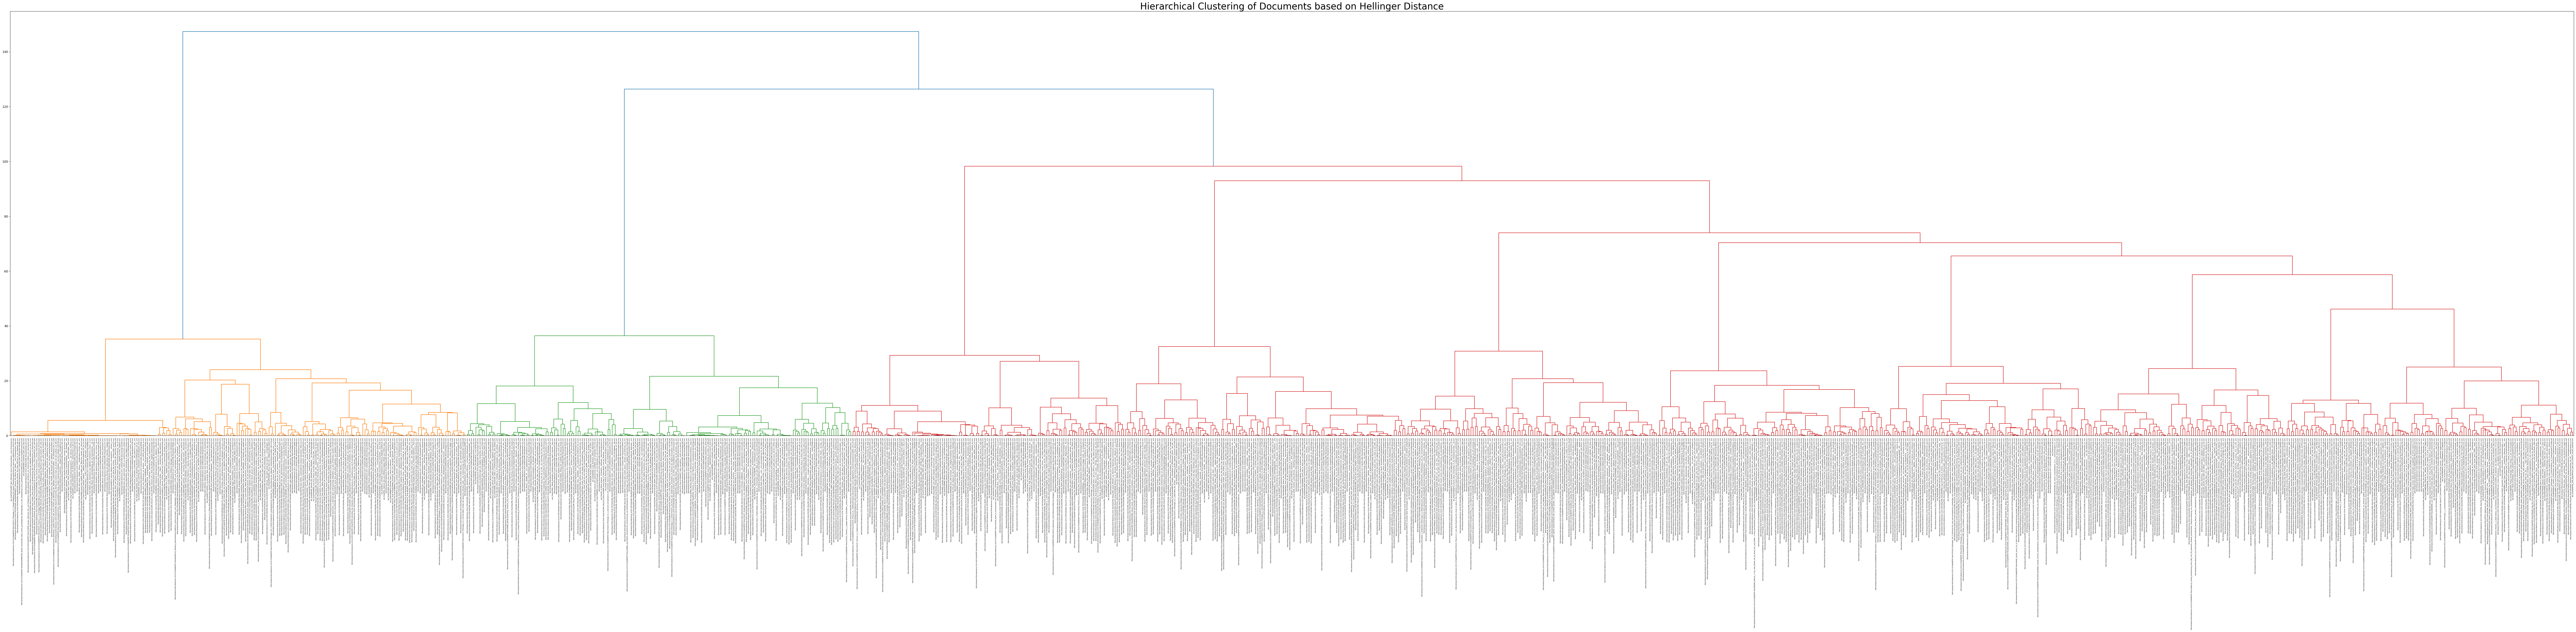

In [68]:
# to label texts with their names and not just index numbers
all_names = []
for list in docnames:
    all_names = all_names + list
    
plt.figure(figsize=(150, 25))  
plt.title("Hierarchical Clustering of Documents based on Hellinger Distance", fontsize = 30) 

dend = shc.dendrogram(shc.linkage(hellinger_distances, method='ward'), labels=all_names, leaf_rotation=90)
plt.savefig('Figures/Dendrogramm_Hellinger_Distances.svg', format='svg')


## Research Question 3: Mann-Kendall-Test

Mann-Kendall-Test:

- MK-Test analyzes whether there is a trend in a topic's appearance over time: increasing, decreasing, no trend (Chen et al., 2020; Mann, 1945)
- in the following, since there are many documents analyzed with topic distributions for each year, the mean value for each topic over all documents was taken to conduct the MK-Test
- [Information on Mann-Kendall-Test](https://www.geeksforgeeks.org/how-to-perform-a-mann-kendall-trend-test-in-python/)

In [156]:
def calculate_topic_average(indexes, topics_per_text):
    # calculating the average probability of a certain topic per year
    averages_per_topic_per_year = []
    i = 0 
    j = 1
    while i < int(len(indexes)-1):
        all_probs = []
        for text in topics_per_text[indexes[i]:indexes[j]]:
            probs = []
            for tuple in text:
                topic, probability = tuple
                # extracting only the probability values from the tuple
                probs.append(probability)
            all_probs.append(probs)
        # dividing the sum of all first, second, third... values by the number of values to get the average of all n topics for one year
        averages_per_topic = (np.sum(all_probs, axis=0)/len(all_probs))
        averages_per_topic_per_year.append(averages_per_topic)
        i +=1
        j += 1
    return averages_per_topic_per_year

In [229]:
# using the list of names of documents for each year to count how many documents belong to one year
indexes = [0]
for sublist in docnames:
    indexes.append(len(sublist) + indexes[-1])

topic_averages = calculate_topic_average(indexes, topics_per_text)

# creating a dataframe which shows the average probability of a topic in each year
df = pd.DataFrame(topic_averages, index=filenames).T
print(df)


   DHd_2014.zip  DHd_2015.zip  DHd_2016.zip  DHd_2017.zip  DHd_2018.zip   
0      0.076075      0.084743      0.065551      0.085898      0.071754  \
1      0.133152      0.154729      0.132367      0.160513      0.133562   
2      0.122159      0.121306      0.115162      0.059113      0.103149   
3      0.071972      0.035081      0.044801      0.030105      0.049052   
4      0.041786      0.033521      0.020088      0.052179      0.044465   
5      0.111895      0.161814      0.220163      0.167589      0.164435   
6      0.208630      0.179081      0.204124      0.225091      0.237317   
7      0.125103      0.066924      0.080386      0.120097      0.069346   
8      0.067732      0.059499      0.050089      0.058108      0.055269   
9      0.041495      0.103302      0.067269      0.041308      0.071652   

   DHd_2019.zip  DHd_2020.zip  DHd_2022.zip  DHd_2023.zip  
0      0.077367      0.079602      0.052877      0.056550  
1      0.125768      0.111077      0.100821      0.143

Visualisation of the development of topic probability averages per year

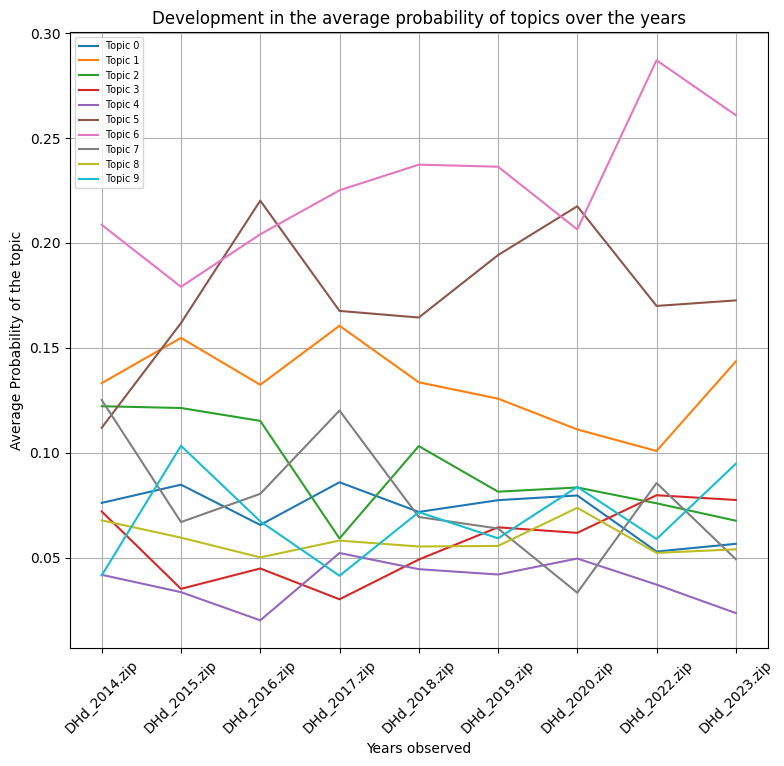

In [177]:
# creating a plot for visualisation
plt.figure(figsize=(9,8))
plt.title("Development in the average probability of topics over the years")
plt.xlabel("Years observed")
plt.ylabel("Average Probability of the topic")

plt.xticks(rotation=45)
for i in range(0, final_num_topics):  
    # creating a line plot showing the development trends of each topic per year
    plt.plot(filenames, df.values[i], label=str('Topic ' + str(i)))
    plt.legend(loc='best', fontsize='x-small')
plt.grid(True)
plt.savefig('Figures/TopicProbabilitiesPerYear.svg', format='svg') 
plt.show()
  


Mann-Kendall-Test for each topic:

- results are statistically significant if p <= 0.05
- results are highly statistically significant if p <= 0.01

In [180]:
for i in range(0, final_num_topics, 1):
    # MK-Test for each topic and its average value
    print(i, mk.original_test(df.values[i]))


0 Mann_Kendall_Test(trend='no trend', h=False, p=0.34808262363292397, z=-0.9383148632568366, Tau=-0.2777777777777778, s=-10.0, var_s=92.0, slope=-0.0022695225973924, intercept=0.08515309294064839)
1 Mann_Kendall_Test(trend='no trend', h=False, p=0.2514521865080219, z=-1.1468292773139113, Tau=-0.3333333333333333, s=-12.0, var_s=92.0, slope=-0.004148871770926884, intercept=0.1497473610298974)
2 Mann_Kendall_Test(trend='decreasing', h=True, p=0.01648865672767008, z=-2.39791576165636, Tau=-0.6666666666666666, s=-24.0, var_s=92.0, slope=-0.007552470390995344, intercept=0.11361457904179892)
3 Mann_Kendall_Test(trend='no trend', h=False, p=0.11785089502136503, z=1.563858105428061, Tau=0.4444444444444444, s=16.0, var_s=92.0, slope=0.005747816170610133, intercept=0.03879111402091526)
4 Mann_Kendall_Test(trend='no trend', h=False, p=0.9169652366288645, z=-0.10425720702853739, Tau=-0.05555555555555555, s=-2.0, var_s=92.0, slope=-0.0007724896782920474, intercept=0.04487586198818116)
5 Mann_Kendall

## Research Question 4: Development and Use of Research Methods

There are two types of keywords used in the xml-files of the DHd-Conferences: \<keywords n="topics" scheme="ConfTool"> and \<keywords n="keywords" scheme="ConfTool">. The former may be used by authors to freely annotate their xml-file with words which they want to be in the metadata, while the latter one only allows for a selection of keywords.
From 2016 on, authors to the conference could select keywords to be used in the xml-file to their contribution. The list of keywords is 75 items long, out of which six can currently be selected for the xml-file. Yet, in 2016 and 2017, this restriction has not been made, so that authors could select more than six keywords for the metadata. The full list of usable keywords is called 'conf_tool_methods' and will be used in the following.

In [28]:
def open_list(doc_name):
    file = open(doc_name, "r", encoding='utf-8')
    data = file.read()

    data = data.split(", ")
    return data
    file.close()

In [233]:
def find_popular_methods(methods):
    # takes sorted list as input in which the methods used and their count (how often were they used/stated as keyword in each year?) is saved
    popular_methods = []
    for year in methods:
        # extracts the first five methods (the ones with the highest count) and appends them to another list, in which only the method itself is saved
        best_five = year[:5]
        for item in best_five: 
            res_method, count = item
            if res_method not in popular_methods:
                popular_methods.append(res_method)
    return popular_methods

In [225]:
def count_keywords(complete_list, year_list):
    
    # for each year, a large list of all possible, freely annotated keywords is set up and the count for each of the keywords is set to 0
    # if the method appears in the specific year's list, +1 will be added to the count
     
    big_list = []
    for year in year_list:
        dict = {}
        for method in complete_list:
            dict[method] = 0
        for method in year:
                dict[method] += 1
        # sorting the dict according to the count, so that the item with the highest count comes first
        sorted_dict = sorted(dict.items(), key=lambda x: x[1], reverse=True)
        big_list.append(sorted_dict)
        
    return big_list

In [262]:
def calculate_relative_count(popular_methods, count_keywords, number_xml_docs):
    
    # for the popular methods, it is looked at how often they appear in each year's corpus
    # then, that count will be divided by the total number of texts in that corpus, which results in a proportional frequency of the keyword to the corpus size 
    relative_dict = {}
    for item in popular_methods:
        item_count = []
        for year in count_keywords:
            i = 0
            for tuple in year:
                name, count = tuple
                if name == item:
                    item_count.append(round(count/number_xml_docs[i], 3))
            i += 1
        relative_dict[item] = item_count
        
    return relative_dict

In [269]:
# importing the list provided, which contains all selectable options for <keywords n='keywords'>
conf_tool_methods = open_list('conf_tool_methods.txt')

# how many texts are in each year's corpus taken into account?
number_xml_docs = []      
for sublist in doc_names_xml:
  number_xml_docs.append(len(sublist))
  
# analysing the freely-selected keywords
count_free_keywords = count_keywords(all_free_keywords, keywords_free_total)
popular_free_methods = find_popular_methods(count_free_keywords)
free_relative = calculate_relative_count(popular_free_methods, count_free_keywords, number_xml_docs)

[[('Visualisierung', 19), ('Annotation', 8), ('Semantic Web', 8), ('Modellierung', 6), ('Forschungsdaten', 5), ('Kollaboration', 5), ('Langzeitarchivierung', 5), ('Korpuslinguistik', 5), ('Vernetzung', 4), ('TEI', 4), ('XML', 4), ('Literatur', 4), ('Digitalisierung', 4), ('Stilometrie', 4), ('Infrastruktur', 3), ('Crowdsourcing', 3), ('Korpora', 3), ('NLP', 3), ('Ontologie', 3), ('Forschungsinfrastruktur', 3), ('Textanalyse', 3), ('DARIAH-DE', 3), ('Datenmodellierung', 2), ('Dokumentation', 2), ('Nachhaltigkeit', 2), ('CLARIN-D', 2), ('Edition', 2), ('Open Access', 2), ('Forschungsdatenmanagement', 2), ('Autorschaft', 2), ('Taxonomie', 2), ('Literaturgeschichte', 2), ('Netzwerkanalyse', 2), ('Handschrift', 2), ('Online Edition', 2), ('XML-TEI', 2), ('Korpus', 2), ('CIDOC CRM', 2), ('Metadaten', 2), ('Emotionen', 2), ('Lexikografie', 2), ('Digitale Edition', 2), ('Ontologien', 2), ('Literaturwissenschaft', 2), ('Archivierung', 2), ('Sprachdokumentation', 2), ('Natural Language Processin

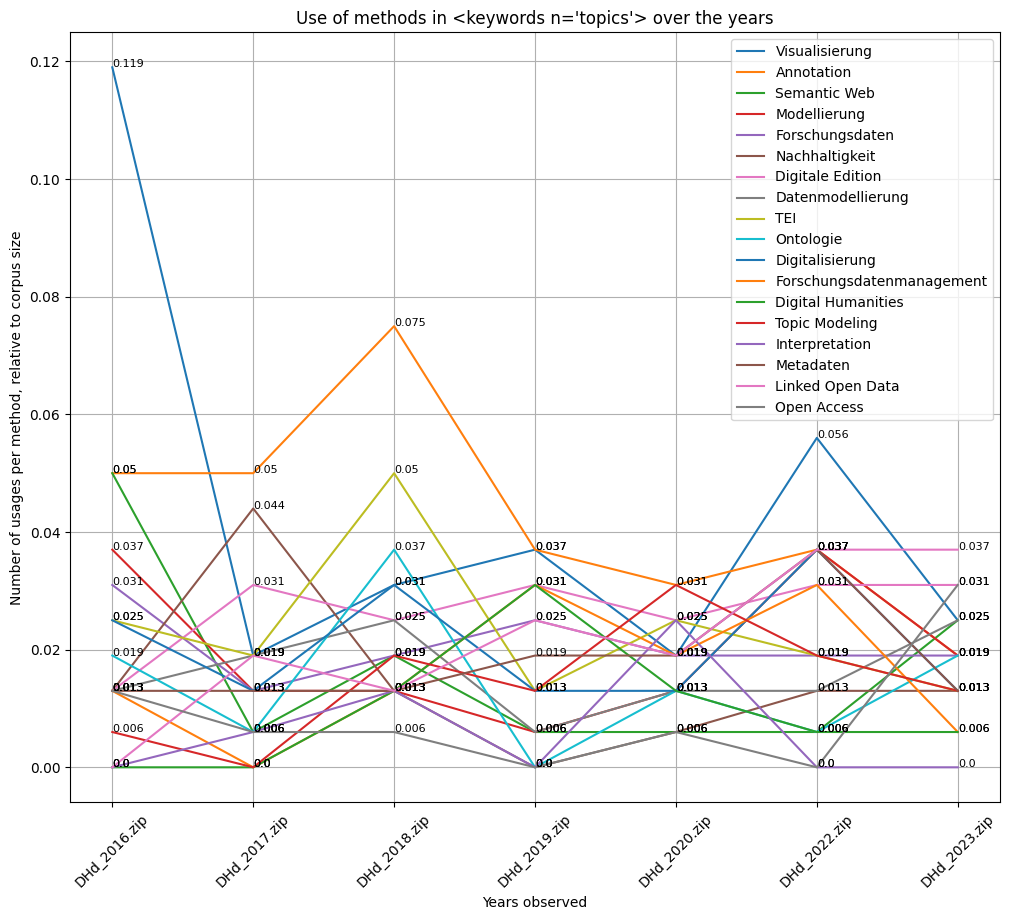

' If grid is used, maybe delete the numbers for each data point? '

In [277]:
# creating a plot for visualisation
fig, ax = plt.subplots(figsize=(12,10))
# plt.figure(figsize=(10,8))
plt.title("Use of methods in <keywords n='topics'> over the years")
plt.xlabel("Years observed")
plt.ylabel("Number of usages per method, relative to corpus size")

plt.xticks(rotation=45)
for key in free_relative:
      plt.plot(filenames_xml, free_relative[key], label=key)
      # following 2 lines are for creating the small numbers at each data point
      for index in range(len(filenames_xml)):
        ax.text(filenames_xml[index], free_relative[key][index], free_relative[key][index], size=8)
      plt.legend(loc='upper right')
plt.grid(True)
plt.savefig('Figures/Free_ResearchMethodsPerYear.svg', format='svg')
plt.show()  

In [286]:
# for complete information, a csv-file is provided with all used keywords and their relative counts
free_relative_all = calculate_relative_count(all_free_keywords, count_free_keywords, number_xml_docs)
df = pd.DataFrame(free_relative_all.values(), index=free_relative_all.keys(),columns=filenames_xml)
df.to_csv('Figures/Free_Keywords_All.csv')

In [278]:
# analysis of predetermined keywords
count_conf_keywords = count_keywords(conf_tool_methods, keywords_conf_total)
popular_conf_methods = find_popular_methods(count_conf_keywords)
conf_relative = calculate_relative_count(popular_conf_methods, count_conf_keywords, number_xml_docs)

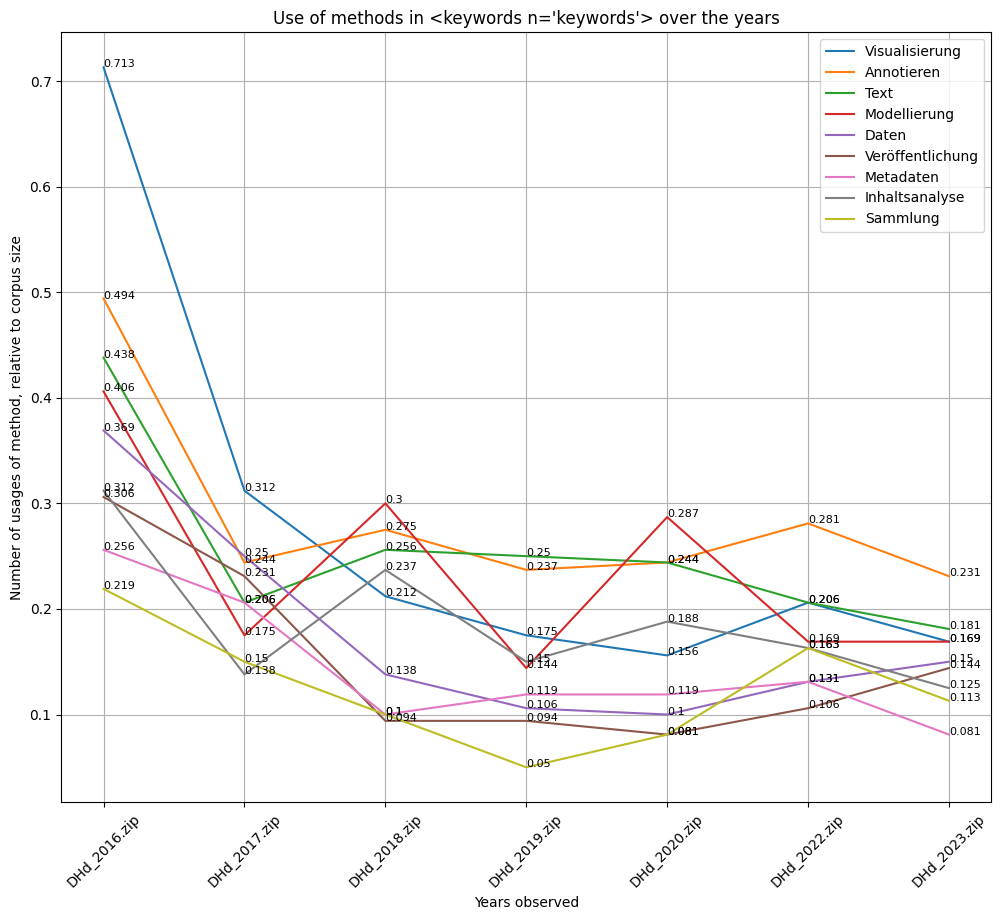

In [276]:
# creating a plot for visualisation
fig, ax = plt.subplots(figsize=(12,10))
# plt.figure(figsize=(10,8))
plt.title("Use of methods in <keywords n='keywords'> over the years")
plt.xlabel("Years observed")
plt.ylabel("Number of usages of method, relative to corpus size")

plt.xticks(rotation=45)
for key in conf_relative:
      plt.plot(filenames_xml, conf_relative[key], label=key)
      # following 2 lines are for creating the small numbers at each data point
      for index in range(len(filenames_xml)):
        ax.text(filenames_xml[index], conf_relative[key][index], conf_relative[key][index], size=8)
      plt.legend(loc='upper right')
plt.grid(True)
plt.savefig('Figures/Conf_ResearchMethodsPerYear.svg', format='svg')
plt.show()  


In [285]:
# for complete information, a csv-file is provided with all used keywords and their relative counts
conf_relative_all = calculate_relative_count(conf_tool_methods, count_conf_keywords, number_xml_docs)
df = pd.DataFrame(conf_relative_all.values(), index=conf_relative_all.keys(),columns=filenames_xml)
df.to_csv('Figures/Conf_Keywords_All.csv')

                                DHd_2016.zip  DHd_2017.zip  DHd_2018.zip   
Aufzeichnung                           0.075         0.025         0.006  \
Bilderfassung                          0.106         0.031         0.025   
Datenerkennung                         0.150         0.087         0.056   
Entdeckung                             0.156         0.069         0.069   
Sammlung                               0.219         0.150         0.100   
...                                      ...           ...           ...   
Text                                   0.438         0.206         0.256   
texttragende Gegenstände               0.069         0.037         0.037   
Werkzeuge                              0.263         0.081         0.081   
Video                                  0.037         0.019         0.025   
virtuelle Forschungsumgebungen         0.181         0.062         0.031   

                                DHd_2019.zip  DHd_2020.zip  DHd_2022.zip   
Aufzeichnun

## Research Question 5: Analysis of Authors and Teams of Authors


*Which researchers contribute to the conference particularly frequently with abstracts, in which teams do they contribute and how have the teams been changing?*

In [ ]:
# helping function to determine the color of the network's edges, depending on how often authors worked together in that year
def determine_edge_color(coauthor_count):
      if coauthor_count >= 3:
            return '#360BFA'
      else: 
        return '#6CEAFB'

In [73]:
''' Funktion erstellen !! '''

# returns list of authors and number of their appearances over the years

authors_sorted_count = []
authors_list_per_year = []
top_10_authors = []
for year in authors:
    for team in year:
        authors_list_per_year = authors_list_per_year + team
    authors_sorted_count.append((count_appearances(authors_list_per_year))[10:])
    top_10_authors.append((count_appearances(authors_list_per_year))[:10])
    authors_list_per_year = [] 


[('Kuroczyński, Piotr', 2), ('Pfeil, Patrick', 2), ('Aehnlich, Barbara', 2), ('Engelhardt, Claudia', 2), ('Kurzawe, Daniel', 2), ('Wiedemann, Gregor', 2), ('Würzner, Kay-Michael', 2), ('Durco, Matej', 2), ('Stäcker, Thomas', 2), ('Thomas, Christian', 2), ('Keim, Daniel A.', 2), ('Steyer, Timo', 2), ('Kleineberg, Michael', 2), ('Kaden, Ben', 2), ('Fischer, Frank', 2), ('Trilcke, Peer', 2), ('Kampkaspar, Dario', 2), ('Ivanovic, Christine', 2), ('Herteis, Simeon', 2), ('Witt, Andreas', 2), ('Pielström, Steffen', 2), ('Rißler-Pipka, Nanette', 2), ('Fichtner, Mark', 2), ('Wandl-Vogt, Eveline', 2), ('Schmid, Oliver', 2), ('Kuczera, Andreas', 2), ('Ertl, Thomas', 2), ('Kantner, Cathleen', 2), ('Richter, Sandra', 2), ('Müller-Birn, Claudia', 2), ('Schmidt, Thomas', 2), ('Zhekova, Desislava', 2), ('Christlein, Vincent', 2), ('Heyer, Gerhard', 2), ('Senft, Björn', 2), ('Vogel, Friedemann', 2), ('Lauer, Gerhard', 2), ('Meißner, Cordula', 2), ('Wallner, Franziska', 2), ('Rapp, Andrea', 2), ('Gradl

In [22]:
''' Funktion erstellen !! '''
coauthors_list = []
coauthors_per_year = []

for conference_year in authors:
    for document_authors in conference_year:
        if len(document_authors) >= 2:
            for i in range(len(document_authors)-1):
                for j in range(i+1, len(document_authors), 1):
                    coauthors_list.append((document_authors[i], document_authors[j]))              
    dict_coauthors_count = count_appearances(coauthors_list)      
    coauthors_per_year.append(dict_coauthors_count) 
    coauthors_list = []
     
save_object('Variables/', 'coauthors_per_year.pckl', coauthors_per_year)


In [84]:
# implementing the network for each year


colors = ['green', 'red', 'blue', '#CE1AE3', '#1AE37B', '#5B42CC', 'yellow', 'orange']
years = ['2016', '2017', '2018', '2019', '2020', '2022', '2023']

i = 0
for year in years:
  # implementing the network itself for each year
  g = Network(height='750px', width='90%', cdn_resources='remote', select_menu=True, font_color='black')
  nxg = nx.complete_graph(0)
  g.from_nx(nxg)
  
  # adding nodes for less frequent authors
  for author in authors_sorted_count[0]:
    name, total_count = author
    g.add_node(name, 
              title=name, 
              label=name, 
              size=(total_count*10), 
              color=colors[i],
              borderWidth=1, 
              borderWidthSelected=3,
              shape='dot'
              )
  # adding nodes for the top 10 most contributing authors each year 
  for author in top_10_authors[0]:
    name, total_count = author
    g.add_node(name, 
              title=name, 
              label=name, 
              size=(total_count*10), 
              color=colors[i+1],
              borderWidth=1, 
              borderWidthSelected=3,
              shape='star'
              )

  # adding the edges between authors, color depending on how often authors worked togehter
  for item in coauthors_per_year[0]:
    name1 = item[0][0]
    name2 = item[0][1]
    coauthor_count = item[1]
    col_select = determine_edge_color(coauthor_count)
    g.add_edge(name1, name2, 
              width=(coauthor_count*10),
              color = col_select,
              smooth=False,
              physics=False
              )
    
  # g.show_buttons(filter_=['nodes'])
#   g.set_options("""
#                 const options = {
#   "physics": {
#     "hierarchicalRepulsion": {
#       "centralGravity": 0,
#       "springLength": 70,
#       "nodeDistance": 320,
#       "damping": 0.96,
#       "avoidOverlap": 0.91
#     },
#     "minVelocity": 0.75,
#     "solver": "hierarchicalRepulsion"
#   }
# }""")
  
  # algorithm used to portray the network
  g.hrepulsion()
  
  # writing an html-file
  html = g.generate_html()
  name = 'Figures/Authors_Networks_' + str(years[i]) + '.html'
  with open(str(name), mode='w', encoding='utf-8') as fp:
    fp.write(html)
  i += 1




## Research Question 6: Clustering of (Teams of) Authors and certain Research Topics

*Which clusters of researchers can be found with regard to topics and how have the clusters been changing?* **Network Analysis**